# Notebook

The output quantized mesh has some problems in cesium, because meshing and calculating normals is done on one tile we get seems between tiles in Cesium. The quantized mesh specification mentions that tile edges need to have shared vertices with neighbouring tiles. In this notebook we go over the steps to achieve shared edge vertices.

### Import and setup

Let's setup some imports and settings for this notebook


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import triangle
import plotly.graph_objects as go
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint, GeometryCollection

from ctod.core.cog import download_tile
from ctod.core.utils import get_tms, get_tile_bounds
from ctod.core.mesh import generate_mesh

%pip install --upgrade nbformat

tms = get_tms()
geotiff_path = "/home/time/Downloads/cog/dtm_cog.tif"

Note: you may need to restart the kernel to use updated packages.


### Download 2 tiles

For this example we use 2 adjecent tiles instead of a tile with north, east, south and west neighbors to keep it simple. Here we download/extract 2 tiles in norway from a Tiff (COG) resulting in a np array with height x,y,z data and display the height.

In [2]:
# north tile
north_x, north_y, north_z = 67501, 10799, 16
north = download_tile(tms, north_x, north_y, north_z, geotiff_path)
tile_bounds_north = get_tile_bounds(tms, north_x, north_y, north_z)

# south tile
south_x, south_y, south_z = 67501, 10798, 16
south = download_tile(tms, south_x, south_y, south_z, geotiff_path)
tile_bound_south = get_tile_bounds(tms, south_x, south_y, south_z)

#### Visualise north and south tile data from COG

Let's visualise the data from the COG to see what we are working with.

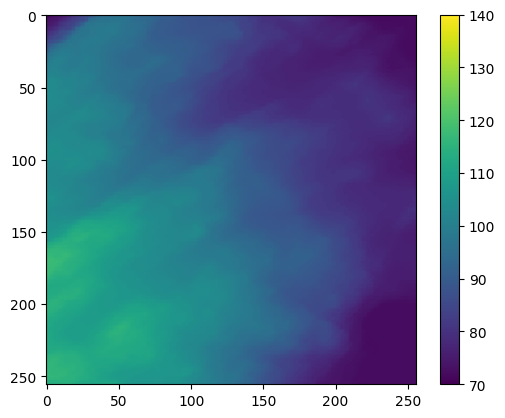

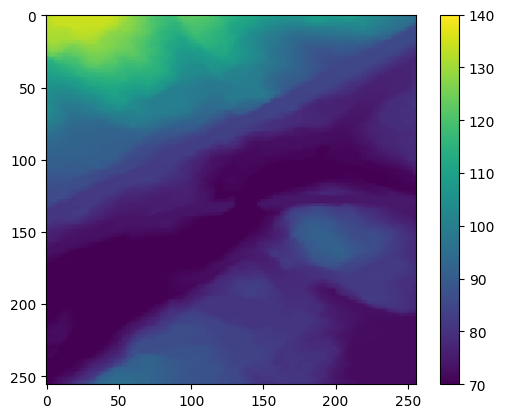

In [31]:
# set the min and max height for the height color, this works for the current dataset
vmin = 70
vmax = 140
cmap = 'viridis'

# Show north tile
plt.imshow(north.data[0], cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

# Show south tile
plt.imshow(south.data[0], cmap=cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

### Run pydelatin to create a mesh for the the tiles

The next step is running pydelation on our image data, this creates our starting mesh

In [4]:
# Mesh error can be changed, we set it to 1.5 to get nice details, lower the number to get a more detailed mesh
mesh_error = 1.5

# get the vertices and triangles for the north and south tile, generate_mesh is calling pydelatin under the hood
north_vertices, north_triangles = generate_mesh(north.data[0], mesh_error)
south_vertices, south_triangles = generate_mesh(south.data[0], mesh_error)

#### Visualize the generated mesh

Here we check the output of pydelatin for our north tile. The output looks good

In [5]:
x, y, z = north_vertices[:, 0], north_vertices[:, 1], north_vertices[:, 2]
i, j, k = north_triangles[:, 0], north_triangles[:, 1], north_triangles[:, 2]
color_scale = z
mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=color_scale, colorscale='Viridis', opacity=0.8, flatshading=True)
wireframe = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='rgba(0,0,0,0.2)')
layout = go.Layout(scene=dict(aspectmode="data"))
fig = go.Figure(data=[mesh, wireframe], layout=layout)
fig.show()

### Combine meshes

Pydelatin creates vertices and triangles from the image data but does not know anything about surrounding data and sharing vertices. We need to somehow add the edge vertices from neighbor tiles into a tile to get shared edge vertices.

#### How do the tiles look without shared edge vertices

Here is a small example

In [6]:
# Calculate the maximum y-coordinate value in north_vertices
# should always be 255
max_y_north = np.max(north_vertices[:, 1])

# Offset the y-coordinates of south_vertices by max_y_north
south_vertices_offset = south_vertices.copy()
south_vertices_offset[:, 1] += max_y_north

# Combine vertices
all_vertices = np.concatenate((north_vertices, south_vertices_offset), axis=0)

# Offset the triangle indices for south_triangles and combine
south_triangles_offset = south_triangles + len(north_vertices)

all_triangles = np.concatenate((north_triangles, south_triangles_offset), axis=0)


In the below result you can already spot the seem between the tile, when showing normals this is much more pronounced. There is also a height difference that can be spotted which we need to overcome.

In [7]:
x, y, z = all_vertices[:, 0], all_vertices[:, 1], all_vertices[:, 2]
i, j, k = all_triangles[:, 0], all_triangles[:, 1], all_triangles[:, 2]
color_scale = z
mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=color_scale, colorscale='Viridis', opacity=0.8, flatshading=True)
wireframe = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='rgba(0,0,0,0.2)')
layout = go.Layout(scene=dict(aspectmode="data"))
fig = go.Figure(data=[mesh, wireframe], layout=layout)
fig.show()

### Exploring option to triangulate over multiple tiles

Below we test the option to first combine all vertices, triangulate, get all vertices inside tile bounds and generate vertices for overlapping triangles, triangulate again, resample height with calculated height on the edge.

In [8]:
# Run constrained Delaunay triangulation 

# tile already contains vertices around the edges
south_tile_bounds = [
    [0, 0], 
    [255, 0], 
    [255, 255], 
    [0, 255],
    [0, 0]]

north_tile_bounds = [
    [0, 255], 
    [255, 255], 
    [255, 510], 
    [0, 510],
    [0, 255]]

# Project 3D vertices onto a 2D plane
projected_vertices = all_vertices[:, :2]

# Perform 2D constrained Delaunay triangulation
tri = triangle.triangulate(
    {'vertices': projected_vertices, 'segments': south_tile_bounds},
    'apqc'
)

Show the result of our 2d triangulated over all vertices

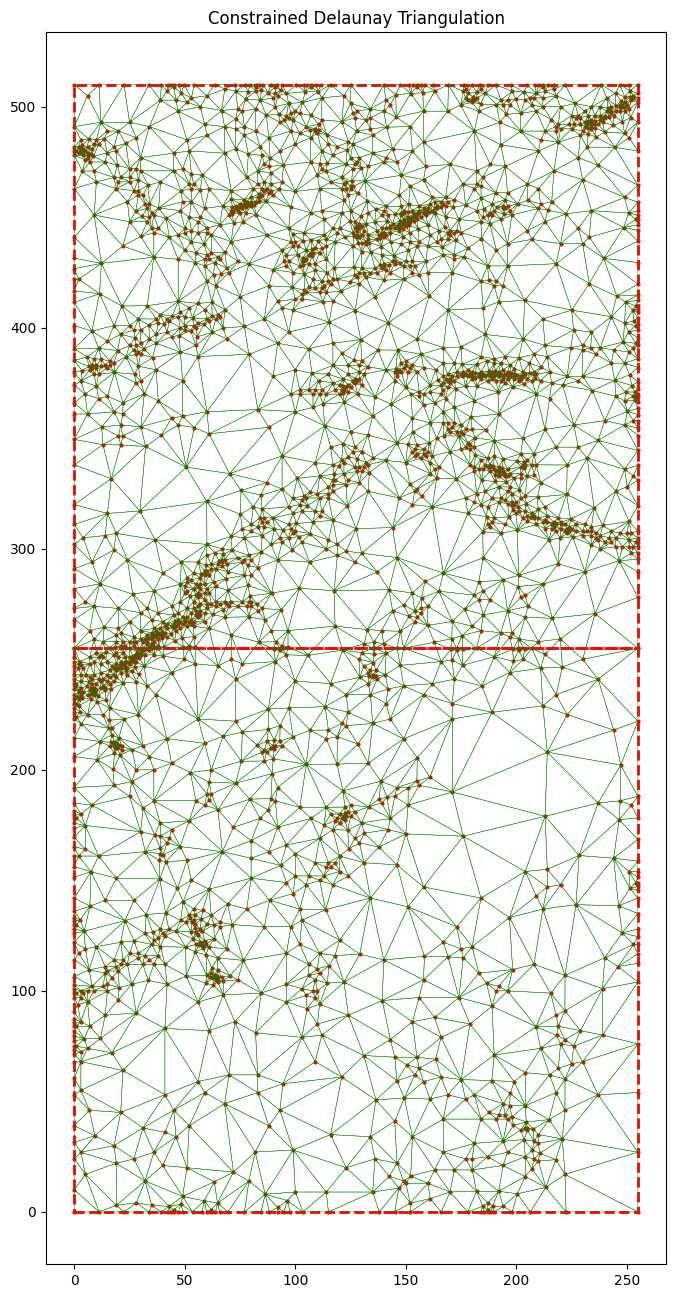

In [9]:
tri_vertices = tri['vertices']
tri_triangles = tri['triangles']
constraints = [south_tile_bounds]

fig, ax = plt.subplots(figsize=(8, 16))

plt.scatter(tri_vertices[:, 0], tri_vertices[:, 1], c='red', marker='o', s=4)

south_tile_bounds = np.array(south_tile_bounds)  # Convert to NumPy array for slicing
plt.plot(south_tile_bounds[:, 0], south_tile_bounds[:, 1], 'r--', linewidth=2.0)

north_tile_bounds = np.array(north_tile_bounds)  # Convert to NumPy array for slicing
plt.plot(north_tile_bounds[:, 0], north_tile_bounds[:, 1], 'r--', linewidth=2.0)

for triangle_indices in tri_triangles:
    triangle_vertices = tri_vertices[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)


plt.axis('equal')
plt.title('Constrained Delaunay Triangulation')
plt.show()

In [10]:
# function to get the coordinates of a shapely geometry

def extract_coords(geometry):
    if isinstance(geometry, Point):
        return np.array([list(geometry.coords)[0]])
    elif isinstance(geometry, LineString):
        return np.array(list(geometry.coords))
    elif isinstance(geometry, MultiPoint):
        return np.array([list(point.coords)[0] for point in geometry.geoms])
    elif isinstance(geometry, MultiLineString):
        return np.vstack([list(line.coords) for line in geometry.geoms])
    else:
        raise ValueError("Unhandled geometry type:", type(geometry))

In [11]:
# Function to get vertices inside bounds and generate vertices for overlapping triangles

def get_vertices_inside_bounds(vertices, triangles, tile_bounds):
    # Convert to NumPy array for slicing
    tile_bounds = np.array(tile_bounds)

    # Find vertices inside or touching the north_tile_bounds
    inside_vertices = []

    for point in vertices:
        if np.all((point >= np.min(tile_bounds, axis=0)) & (point <= np.max(tile_bounds, axis=0))):
            inside_vertices.append(point)

    inside_vertices = np.array(inside_vertices)
    bounds_geom = LineString(tile_bounds)

    # Find and add vertices where triangles intersect with bounds
    for triangle_indices in triangles:
        triangle_vertices = vertices[triangle_indices]
        # close triangle
        triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)
        triangle_line = LineString(triangle_vertices)

        intersection_geometry = triangle_line.intersection(bounds_geom)

        if intersection_geometry.is_empty:
            continue
        elif isinstance(intersection_geometry, GeometryCollection):
            # Handle GeometryCollection
            for geom in intersection_geometry.geoms:
                inside_vertices = np.vstack([inside_vertices, extract_coords(geom)])
        else:
            # Handle individual geometries
            inside_vertices = np.vstack([inside_vertices, extract_coords(intersection_geometry)])

    # Remove duplicates from inside_vertices
    inside_vertices = np.unique(inside_vertices, axis=0)
    return inside_vertices


Get/create vertices for our 2 tiles

In [12]:
inside_vertices_south = get_vertices_inside_bounds(tri_vertices, tri_triangles, south_tile_bounds)
inside_vertices_north = get_vertices_inside_bounds(tri_vertices, tri_triangles, north_tile_bounds)

Visualise the overall mesh and extracted vertices for out south tile

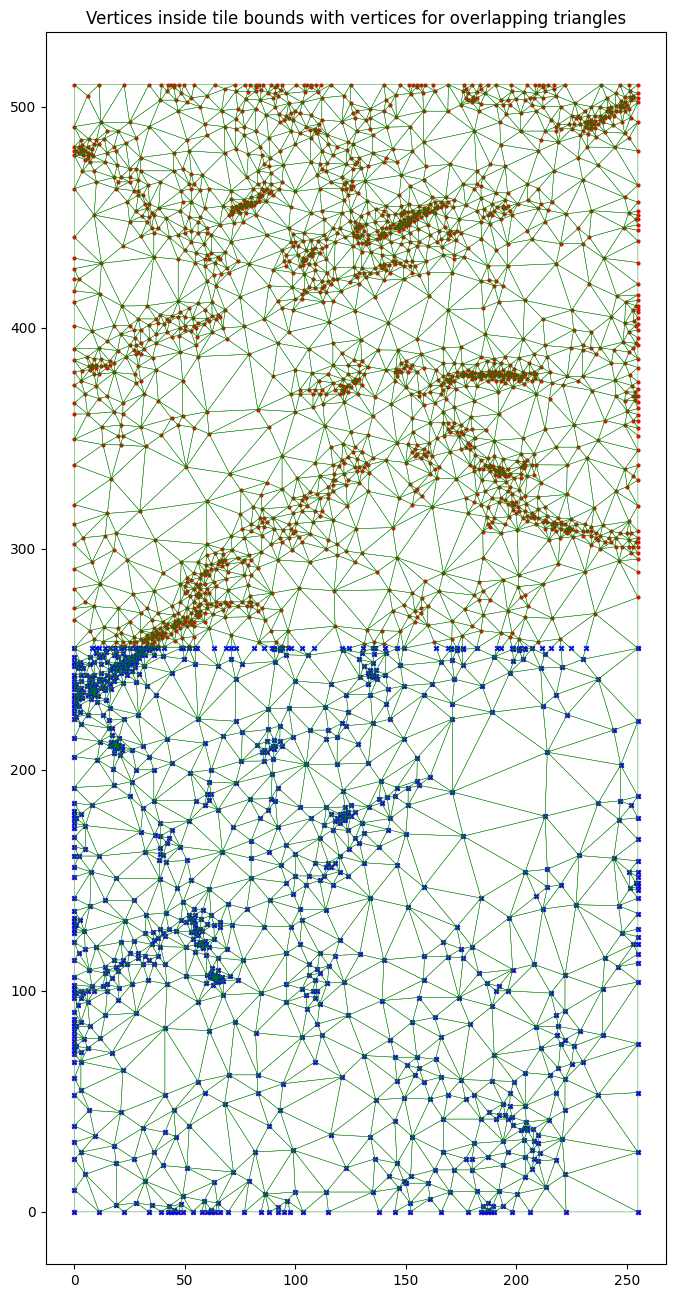

In [13]:
fig, ax = plt.subplots(figsize=(8, 16))

# Plotting code
plt.scatter(tri_vertices[:, 0], tri_vertices[:, 1], c='red', marker='o', s=4)

# Your existing code for triangulation and plotting
for triangle_indices in tri_triangles:
    triangle_vertices = tri_vertices[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)

# Your existing plotting code for triangles and bounds
plt.scatter(inside_vertices_south[:, 0], inside_vertices_south[:, 1], c='blue', marker='x', s=10)
plt.axis('equal')
plt.title('Vertices inside tile bounds with vertices for overlapping triangles')
plt.show()


### Re-triangulate

Above new vertices are introduces and we need to create new triangles per tile, this time having shared vertices around the edge. First move back our vertices to be within a 255 tile. We also resample the height and average the height of the vertices between the 2 tiles

#### North tile

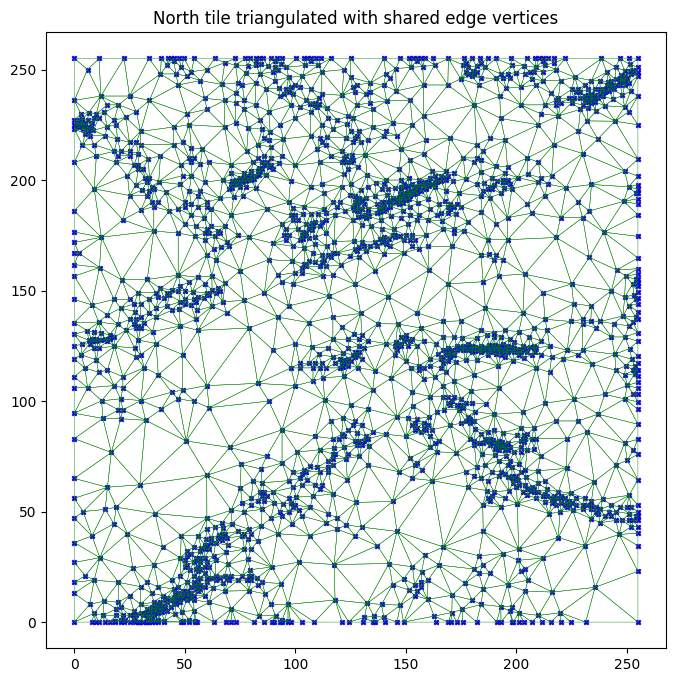

In [14]:
# for north we need to subtract 255 from the y-coordinates
vertices_north_tile = inside_vertices_north.copy()
vertices_north_tile[:, 1] -= 255

# triangulate
tri_north = triangle.triangulate(
    {'vertices': vertices_north_tile, 'segments': [[0, 0], [255, 0], [255, 255], [0, 255], [0, 0]]}
)

vertices_north_tile = tri_north["vertices"]
triangles_north_tile = tri_north["triangles"]

# Resample the height for vertices from the cog
# Sample z-values from image_data based on x and y coordinates
x_indices = vertices_north_tile[:, 0].astype(int)
y_indices = vertices_north_tile[:, 1].astype(int)

# Check if y-coordinate is on the edge
on_edge = (y_indices == 0)

# Calculate z-values
z_values_north = north.data[0][y_indices, x_indices]

# For vertices on the edge, interpolate between south.data[0] and north_data[0]
z_values_south = south.data[0][255, x_indices]
z_values_on_edge = (z_values_north + z_values_south) / 2.0
z_values_on_edge = z_values_on_edge

# Combine z-values for non-edge and edge vertices
z_values = np.where(on_edge, z_values_on_edge, z_values_north)

# Add the sampled z-values as the third column in modified_array
vertices_north_tile = np.column_stack((vertices_north_tile, z_values))
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting code
plt.scatter(vertices_north_tile[:, 0], vertices_north_tile[:, 1], c='red', marker='o', s=4)

# Your existing code for triangulation and plotting
for triangle_indices in triangles_north_tile:
    triangle_vertices = vertices_north_tile[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)

# Your existing plotting code for triangles and bounds
plt.scatter(vertices_north_tile[:, 0], vertices_north_tile[:, 1], c='blue', marker='x', s=10)
plt.axis('equal')
plt.title('North tile triangulated with shared edge vertices')
plt.show()


#### South tile

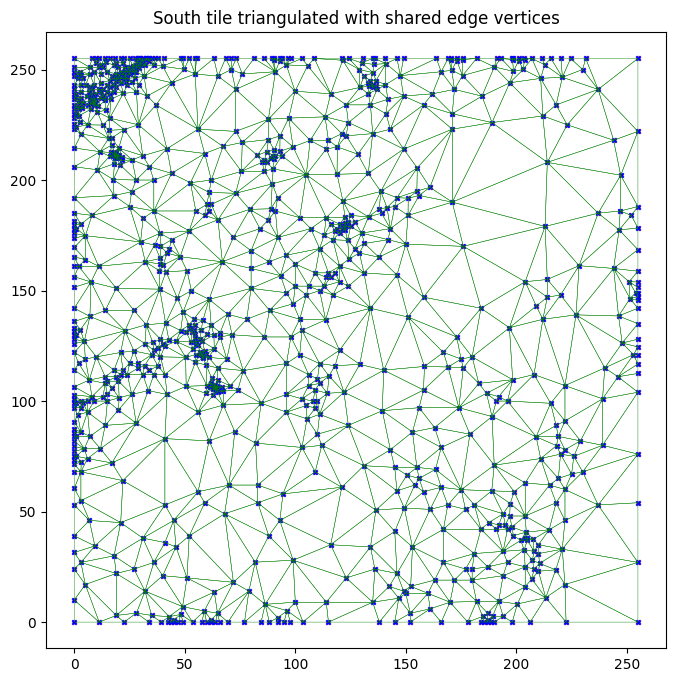

In [15]:
# for south we already have the correct coordinates
vertices_south_tile = inside_vertices_south.copy()

# triangulate
tri_south = triangle.triangulate(
    {'vertices': vertices_south_tile, 'segments': [[0, 0], [255, 0], [255, 255], [0, 255], [0, 0]]}
)

vertices_south_tile = tri_south["vertices"]
triangles_south_tile = tri_south["triangles"]

# Resample the height for vertices from the cog
# Sample z-values from image_data based on x and y coordinates
x_indices = vertices_south_tile[:, 0].astype(int)
y_indices = vertices_south_tile[:, 1].astype(int)

# Check if y-coordinate is on the edge
on_edge = (y_indices == 255)

# Calculate z-values
z_values_south = south.data[0][y_indices, x_indices]

# For vertices on the edge, interpolate between south.data[0] and north_data[0]
z_values_north = north.data[0][0, x_indices]
z_values_on_edge = (z_values_south + z_values_north) / 2.0

# Combine z-values for non-edge and edge vertices
z_values = np.where(on_edge, z_values_on_edge, z_values_south)

# Add the sampled z-values as the third column in modified_array
vertices_south_tile = np.column_stack((vertices_south_tile, z_values))
fig, ax = plt.subplots(figsize=(8, 8))

# Plotting code
plt.scatter(vertices_south_tile[:, 0], vertices_south_tile[:, 1], c='red', marker='o', s=4)

# Your existing code for triangulation and plotting
for triangle_indices in triangles_south_tile:
    triangle_vertices = vertices_south_tile[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)

# Your existing plotting code for triangles and bounds
plt.scatter(vertices_south_tile[:, 0], vertices_south_tile[:, 1], c='blue', marker='x', s=10)
plt.axis('equal')
plt.title('South tile triangulated with shared edge vertices')
plt.show()


### Let's have a look if the mesh looks better now

Put all vertices and triangles together and move 1 tile so the tiles are next to eachother

In [16]:
# Offset the y-coordinates of south_vertices by max_y_north
vertices_north_tile_offset = vertices_north_tile.copy()
vertices_north_tile_offset[:, 1] += 255

# Combine vertices
all_vertices_new = np.concatenate((vertices_south_tile, vertices_north_tile_offset), axis=0)

# Offset the triangle indices for south_triangles and combine
triangles_north_tile_offset = triangles_north_tile + len(vertices_south_tile)
all_triangles_new = np.concatenate((triangles_south_tile, triangles_north_tile_offset), axis=0)

The vertices and triangles are looking ok

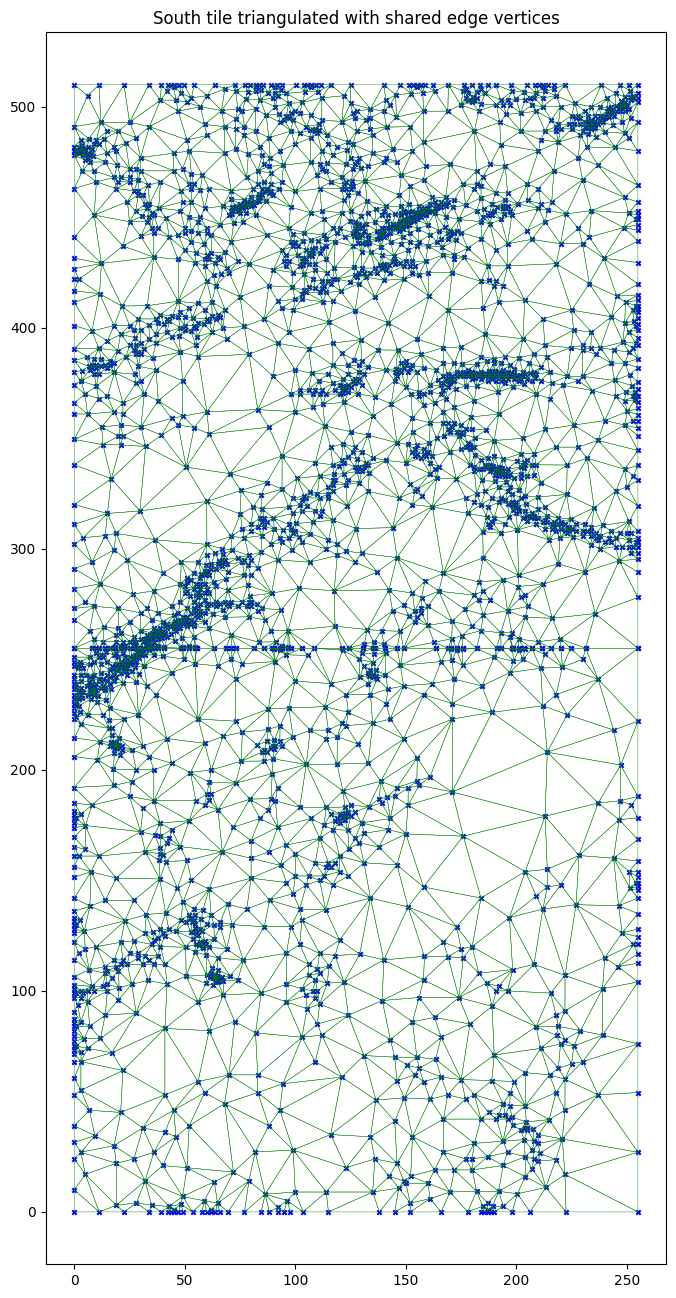

In [17]:
fig, ax = plt.subplots(figsize=(8, 16))

for triangle_indices in all_triangles_new:
    triangle_vertices = all_vertices_new[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)


plt.scatter(all_vertices_new[:, 0], all_vertices_new[:, 1], c='blue', marker='x', s=10)
plt.axis('equal')
plt.title('South tile triangulated with shared edge vertices')
plt.show()

Our 2 new tile meshes next to eachother as a 3D mesh, looks like the seems are gone now, nice.

In [18]:
x, y, z = all_vertices_new[:, 0], all_vertices_new[:, 1], all_vertices_new[:, 2]
i, j, k = all_triangles_new[:, 0], all_triangles_new[:, 1], all_triangles_new[:, 2]
color_scale = z
mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=color_scale, colorscale='Viridis', opacity=0.8, flatshading=True)
wireframe = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='rgba(0,0,0,0.2)')
layout = go.Layout(scene=dict(aspectmode="data"))
fig = go.Figure(data=[mesh, wireframe], layout=layout)
fig.show()

### Is it realy needed to do all the above steps?

combining a tile with all neighboring tiles, triangulating over all of them, extracting vertices, resampling height seems a bit excesive. Can't we just take the neighbor edge vertices, triangulate and be done? Let's try!

vertices and triangles from cog using pydelatin

In [64]:
mesh_error = 1.5
north_vertices_v2, north_triangles_v2 = generate_mesh(north.data[0], mesh_error)
south_vertices_v2, south_triangles_v2 = generate_mesh(south.data[0], mesh_error)

Function to extract vertices from an edge

In [65]:
def get_edge(vertices, direction):
    if direction == "north":
        return vertices[vertices[:, 1] == 255]
    elif direction == "south":
        return vertices[vertices[:, 1] == 0]
    elif direction == "east":
        return vertices[vertices[:, 0] == 255]
    elif direction == "west":
        return vertices[vertices[:, 0] == 0]
    else:
        raise ValueError("Invalid direction:", direction)

#### south tile

In [80]:
# Get the north tile south edge vertices
north_edge_vertices = get_edge(north_vertices_v2, "south")

# set the y of the edge vertices to 255
north_edge_vertices[:, 1] = 255

# Add the edges of the north tile to the south tile
south_all_vertices = np.concatenate((south_vertices_v2, north_edge_vertices), axis=0)

# Make vertices 2D
south_all_vertices_2d = south_all_vertices[:, :2]

# Triangulate with constraint on tile border
triangulation_south = triangle.triangulate(
    {'vertices': south_all_vertices_2d, 'segments': [[0, 0], [255, 0], [255, 255], [0, 255], [0, 0]]}
)

south_vertices_new = triangulation_south["vertices"]
south_triangles_new = triangulation_south["triangles"]

# Resample the height for vertices from the cog
# Sample z-values from image_data based on x and y coordinates
x_indices = south_vertices_new[:, 0].astype(int)
y_indices = south_vertices_new[:, 1].astype(int)

# Check if y-coordinate is on the edge
on_edge = (y_indices == 255)

# Calculate z-values
z_values_south = south.data[0][y_indices, x_indices]

# For vertices on the edge, interpolate between south.data[0] and north_data[0]
z_values_north = north.data[0][0, x_indices]

z_values_on_edge = (z_values_north + z_values_south) / 2.0

# Combine z-values for non-edge and edge vertices
z_values = np.where(on_edge, z_values_on_edge, z_values_south)

# Add the sampled z-values as the third column in modified_array
south_vertices_new = np.column_stack((south_vertices_new, z_values))

#### north tile

In [81]:
# Get the south tile north edge vertices
south_edge_vertices = get_edge(south_vertices_v2, "north")

south_edge_vertices[:, 1] = 0

# Add the edges of the south tile to the north tile
north_all_vertices = np.concatenate((north_vertices_v2, south_edge_vertices), axis=0)

# Make vertices 2D
north_all_vertices_2d = north_all_vertices[:, :2]

# Triangulate with constraint on tile border
triangulation_north = triangle.triangulate(
    {'vertices': north_all_vertices_2d, 'segments': [[0, 0], [255, 0], [255, 255], [0, 255], [0, 0]]}
)

north_vertices_new = triangulation_north["vertices"]
north_triangles_new = triangulation_north["triangles"]

# Resample the height for vertices from the cog
# Sample z-values from image_data based on x and y coordinates
x_indices = north_vertices_new[:, 0].astype(int)
y_indices = north_vertices_new[:, 1].astype(int)

# Check if y-coordinate is on the edge
on_edge = (y_indices == 0)

# Calculate z-values
z_values_north = north.data[0][y_indices, x_indices]

# For vertices on the edge, interpolate between south.data[0] and north_data[0]
z_values_south = south.data[0][255, x_indices]
z_values_on_edge = (z_values_north + z_values_south) / 2.0

# Combine z-values for non-edge and edge vertices
z_values = np.where(on_edge, z_values_on_edge, z_values_north)

# Add the sampled z-values as the third column in modified_array
north_vertices_new = np.column_stack((north_vertices_new, z_values))


#### Show mesh

Looks like we end up with a seemless mesh aswell. 

In [82]:
# Offset the y-coordinates of south_vertices by max_y_north
vertices_north_tile_offset = north_vertices_new.copy()
vertices_north_tile_offset[:, 1] += 255

# Combine vertices
all_vertices_new = np.concatenate((south_vertices_new, vertices_north_tile_offset), axis=0)

# Offset the triangle indices for south_triangles and combine
triangles_north_tile_offset = north_triangles_new + len(south_vertices_new)
all_triangles_new = np.concatenate((south_triangles_new, triangles_north_tile_offset), axis=0)

x, y, z = all_vertices_new[:, 0], all_vertices_new[:, 1], all_vertices_new[:, 2]
i, j, k = all_triangles_new[:, 0], all_triangles_new[:, 1], all_triangles_new[:, 2]
color_scale = z
mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, intensity=color_scale, colorscale='Viridis', opacity=0.8, flatshading=True)
wireframe = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, color='rgba(0,0,0,0.2)')
layout = go.Layout(scene=dict(aspectmode="data"))
fig = go.Figure(data=[mesh, wireframe], layout=layout)
fig.show()

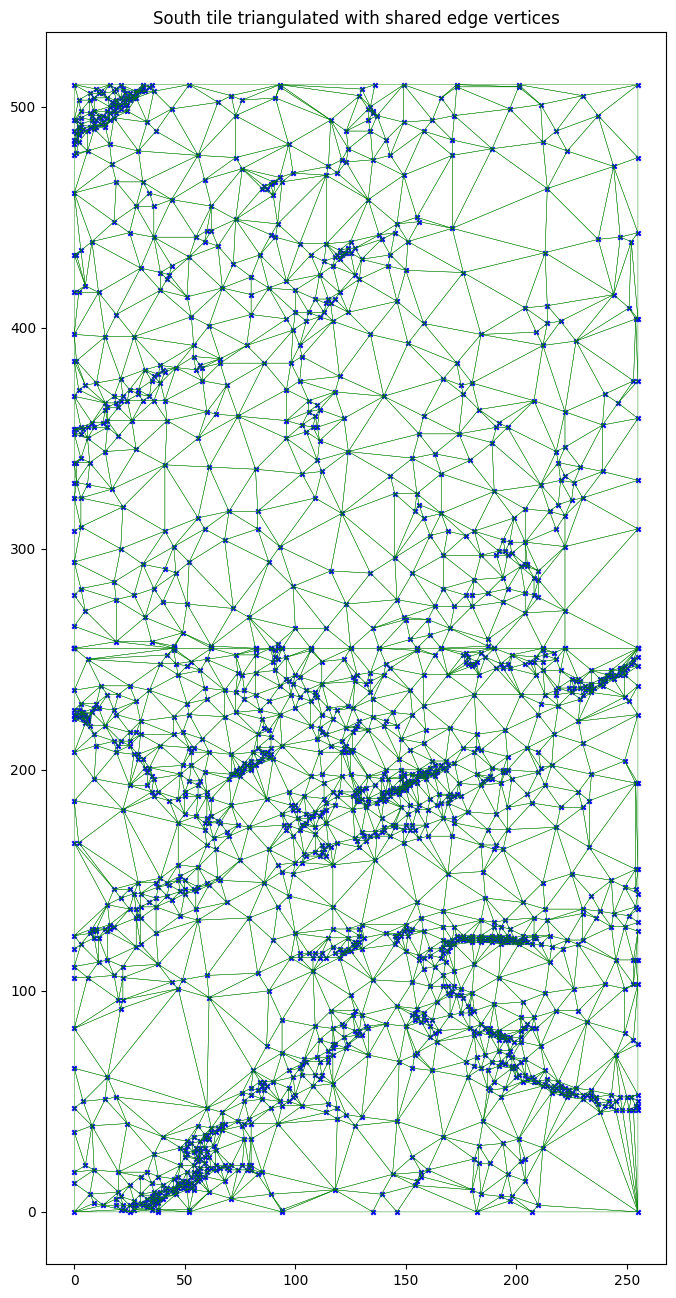

In [77]:
fig, ax = plt.subplots(figsize=(8, 16))

for triangle_indices in all_triangles_new:
    triangle_vertices = all_vertices_new[triangle_indices]
    triangle_vertices = np.append(triangle_vertices, [triangle_vertices[0]], axis=0)  # Close the triangle
    plt.plot(triangle_vertices[:, 0], triangle_vertices[:, 1], 'g-', linewidth=0.3)


plt.scatter(all_vertices_new[:, 0], all_vertices_new[:, 1], c='blue', marker='x', s=10)
plt.axis('equal')
plt.title('South tile triangulated with shared edge vertices')
plt.show()